# Compendium
A text summarizer based on Attention mechanism

### Import required library
The cell below import required library, we will be using torchtext for preprocessing as it does all the prossing for us. 

In [ ]:
#import required library
import math
import dill

import spacy
import seaborn as sns
import matplotlib.ticker as ticker

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

from torchtext.datasets import TranslationDataset
from torchtext.data import Field, BucketIterator, TabularDataset

import time
import random

from helper import *

#set device tp cuda if gpu available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Torchtext Field
Initlizing Field for our source and target feature. using,
1. spacy tokenizer for tokenization. It will use deafult lang for spacy tokenizer ie. English. 
2. defined start of sting and end of string token `<sos>` & `<eos>` respectively. 
3. Further will be using packing of input so for source field changed `include_length` to `True`.

In [ ]:
### initlize Field for source article and target summary
ARTICLE = Field(tokenize='spacy',
                init_token='<sos>',
                eos_token='<eos>',
                lower=True,
                include_lengths=True
                )
SUMMARY = Field(tokenize='spacy',
                init_token='<sos>',
                eos_token='<eos>',
                lower=True,
                )

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load dataset
Used TabularDataset for loading train, test and validation dataset.

In [ ]:
#load train, test, val data
train_data, valid_data, test_data = TabularDataset.splits(
                                                    path=r'/content/drive/My Drive//Ga Ga Megha/',
                                                    train='train1.csv',
                                                    validation='val1.csv',
                                                    test='test1.csv', 
                                                    format='csv',
                                                    fields=[("text",ARTICLE),('headline',SUMMARY)]
                                                        )

In [ ]:
#set up vocab for article and summary from train data.
ARTICLE.build_vocab(train_data, min_freq=2)
SUMMARY.build_vocab(train_data, min_freq=2)

### Checkpoint I
Saving article and summary Field for further use.

In [ ]:
#Save article and summary field as loading it takes around 3-4 mins
with open(r'/content/drive/My Drive//Ga Ga Megha/ARTICLE1.Field1',"wb")as f:
     dill.dump(ARTICLE,f)
with open(r'/content/drive/My Drive//Ga Ga Megha/SUMMARY1.Field1',"wb")as f:
     dill.dump(SUMMARY,f)

### DataIterator
setting up dataloader using BucketIterator. BuketIterator is used because it group data such that minium padding is required.

In [ ]:
#Get train, valid, and test itterator
BATCH_SIZE = 128

train_loader, valid_loader, test_loader = BucketIterator.splits(
                                                            (train_data, valid_data, test_data),
                                                            batch_size=BATCH_SIZE,
                                                            sort_within_batch=True,
                                                            sort_key = lambda x:len(x.text),
                                                            device=device
                                                                )

## Model
Creating encoder decoder seq2seq model using Attention. 
1. It will take a seq of text ie. article, and pass it through encdoder and produce a list of hidden states in each time step. 
2. The list of hidden layer will be input to the decoder layer along with token `<sos>` and hidden states.
3. The attention will take current decoder hidden state and a list of encoder hidden states, calculates score and create context vector based on score.
4. The context vector and ouput of decoder rnn will be concatinated and passed to afully contected feed forward layer to generate ouput.
5. steps 2, 3, 4 will be repeated unitl either max len is achieved or `<eos>` is predicted.

### Encoder
Passes seq of string to budirection GRU to encode it into vectors.

In [ ]:
#Encoder class, encodes article to vector

class Encoder(nn.Module):
    
    
    def __init__(self, vocab, embeding_dim, encoder_hidden_dim, decoder_hidden_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab, embeding_dim)
        self.rnn = nn.RNN(embeding_dim, encoder_hidden_dim, bidirectional = True)
        self.fc = nn.Linear(encoder_hidden_dim*2, decoder_hidden_dim)
        
        self.dropout = nn.Dropout(p=dropout)
   

    def forward(self, text, text_len):
        embedded = self.dropout(self.embedding(text))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_len.cpu())
        packed_outputs, hidden = self.rnn(packed_embedded) 
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        return outputs, hidden

### Attention Mechanism
Takes encoder hidden layer and decoder hidden layer, scores it and return context vector.

In [ ]:
# Attention machanism to take encoder hidden states and current decoder state and generate context vector
class Attention(nn.Module):
    
    
    def __init__(self, enc_hid_dim, dec_hid_dim ):
        super().__init__()
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
    

    def forward(self, hidden, encoder_outputs, mask):      
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        attention = self.v(energy).squeeze(2)
        attention = attention.masked_fill(mask == 0, -1e10)
        
        return F.softmax(attention, dim = 1)

### Decoder
Decoder model takes encoder hidden states and (t-1) input ang generate output with attention mech.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()
        
        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)        
        self.rnn = nn.RNN((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)        
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input_, hidden, encoder_outputs, mask):
    
        input_ = input_.unsqueeze(0)
        embedded = self.dropout(self.embedding(input_))

        atten = self.attention(hidden, encoder_outputs, mask)        
        atten = atten.unsqueeze(1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        weighted = torch.bmm(atten, encoder_outputs)
        
        weighted = weighted.permute(1, 0, 2)        
        rnn_input_ = torch.cat((embedded, weighted), dim = 2)
            
        output, hidden = self.rnn(rnn_input_, hidden.unsqueeze(0))
              
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        return prediction, hidden.squeeze(0), atten.squeeze(1)

### Seq2Seq Model
Encapsulate Encoder Decor model.

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, text_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.text_pad_idx = text_pad_idx
        self.device = device
        
    def create_mask(self, text):
        mask = (text != self.text_pad_idx).permute(1, 0)
        return mask
        
    def forward(self, text, text_len, headline, teacher_forcing_ratio = 0.5):
        batch_size = text.shape[1]
        headline_len = headline.shape[0]
        headline_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(headline_len, batch_size, headline_vocab_size).to(self.device)
      
        encoder_outputs, hidden = self.encoder(text, text_len)
       
        input_ = headline[0,:]
        
        mask = self.create_mask(text)
                
        for t in range(1, headline_len):
            
            output, hidden, _ = self.decoder(input_, hidden, encoder_outputs, mask)           
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio            
            top1 = output.argmax(1)             
            input_ = headline[t] if teacher_force else top1
            
        return outputs

Loading saved article and summary fields. 

In [ ]:
#load saved artucle and summary field 
#only run in case of new or kernal restart

with open(r'/content/drive/My Drive//Ga Ga Megha/ARTICLE1.Field1',"rb")as f:
     ARTICLE=dill.load(f)
with open(r'/content/drive/My Drive//Ga Ga Megha/SUMMARY1.Field1',"rb")as f:
     SUMMARY=dill.load(f)

### Model Initilization 
Initilize model with parameters 

In [ ]:
# model parameters, dimension kept less due to memory issue.

INPUT_DIM = len(ARTICLE.vocab)
OUTPUT_DIM = len(SUMMARY.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
ARTICLE_PAD_IDX = ARTICLE.vocab.stoi[ARTICLE.pad_token]

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, ARTICLE_PAD_IDX, device).to(device)

In [ ]:
print(model)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(50732, 256)
    (rnn): RNN(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(21423, 256)
    (rnn): RNN(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=21423, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)


In [ ]:
torch.save(model.state_dict(), 'checkpoint.pth')

# download checkpoint file
#files.download('checkpoint.pth')

In [ ]:
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

odict_keys(['encoder.embedding.weight', 'encoder.rnn.weight_ih_l0', 'encoder.rnn.weight_hh_l0', 'encoder.rnn.bias_ih_l0', 'encoder.rnn.bias_hh_l0', 'encoder.rnn.weight_ih_l0_reverse', 'encoder.rnn.weight_hh_l0_reverse', 'encoder.rnn.bias_ih_l0_reverse', 'encoder.rnn.bias_hh_l0_reverse', 'encoder.fc.weight', 'encoder.fc.bias', 'decoder.attention.attn.weight', 'decoder.attention.attn.bias', 'decoder.attention.v.weight', 'decoder.embedding.weight', 'decoder.rnn.weight_ih_l0', 'decoder.rnn.weight_hh_l0', 'decoder.rnn.bias_ih_l0', 'decoder.rnn.bias_hh_l0', 'decoder.fc_out.weight', 'decoder.fc_out.bias'])


In [ ]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = fc_model.Network(checkpoint['input_size'],
                             checkpoint['output_size'],
                             checkpoint['hidden_layers'])
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

In [ ]:
# checkpoint = {'input_size': 784,
#               'output_size': 10,
#               'hidden_layers': [each.out_features for each in model.hidden_layers],
#               'state_dict': model.state_dict()}

# torch.save(checkpoint, 'checkpoint.pth')

In [ ]:
# model = load_checkpoint('checkpoint.pth')
# print(model)

###  Optimizer and Cost Function

In [ ]:
#setup optimizer for training model

optimizer = optim.Adam(model.parameters())

In [ ]:
#setiup loss function ignoring pad index

SUMMARY_PAD_IDX = SUMMARY.vocab.stoi[SUMMARY.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = SUMMARY_PAD_IDX)

#### Training and Evalution functions

In [ ]:
#function to train model
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        text, text_len = batch.text
        headline = batch.headline
        
        optimizer.zero_grad()
        
        output = model(text, text_len, headline)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        headline = headline[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, headline)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
#functio to retuen val loss
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            text, text_len = batch.text
            headline = batch.headline

            output = model(text, text_len, headline, 0) #turn off teacher forcing
            
            #headline = [headline len, batch size]
            #output = [headline len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            headline = headline[1:].view(-1)

            #headline = [(headline len - 1) * batch size]
            #output = [(headline len - 1) * batch size, output dim]

            loss = criterion(output, headline)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

#### Training Model
Modl trainig and saving best fitted model

In [ ]:
# trainig model

N_EPOCHS = 10
#N_EPOCHS = 25
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_loader, criterion)
    
    end_time = time.time()
    
    #epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), r'/content/drive/My Drive//Ga Ga Megha/model1.brain')
    
    print(f'Epoch: {epoch+1:2}')
          #| Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch:  1
	Train Loss: 6.444 | Train PPL: 628.926
	 Val. Loss: 5.662 |  Val. PPL: 287.752
Epoch:  2
	Train Loss: 5.363 | Train PPL: 213.428
	 Val. Loss: 4.969 |  Val. PPL: 143.859
Epoch:  3
	Train Loss: 4.766 | Train PPL: 117.431
	 Val. Loss: 4.596 |  Val. PPL:  99.128
Epoch:  4
	Train Loss: 4.380 | Train PPL:  79.846
	 Val. Loss: 4.363 |  Val. PPL:  78.481
Epoch:  5
	Train Loss: 4.091 | Train PPL:  59.815
	 Val. Loss: 4.257 |  Val. PPL:  70.611
Epoch:  6
	Train Loss: 3.895 | Train PPL:  49.180
	 Val. Loss: 4.105 |  Val. PPL:  60.636
Epoch:  7
	Train Loss: 3.730 | Train PPL:  41.667
	 Val. Loss: 4.039 |  Val. PPL:  56.782
Epoch:  8
	Train Loss: 3.594 | Train PPL:  36.397
	 Val. Loss: 3.969 |  Val. PPL:  52.949
Epoch:  9
	Train Loss: 3.498 | Train PPL:  33.043
	 Val. Loss: 3.915 |  Val. PPL:  50.139
Epoch: 10
	Train Loss: 3.398 | Train PPL:  29.912
	 Val. Loss: 3.880 |  Val. PPL:  48.441


#### Load best fitted model

In [ ]:
#load best fitted model and calculate test loss
model.load_state_dict(torch.load(r'/content/drive/My Drive//Ga Ga Megha/model1.brain', map_location=device))

test_loss = evaluate(model, test_loader, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.876 | Test PPL:  48.232 |


## Prediction
Predicting generated summary along with its attention matrix

In [ ]:
#function to dengerate summary from saved model
def predict(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        
    if sentence is str:
        nlp = spacy.load('en')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)
    src_len = torch.LongTensor([len(src_indexes)]).to(device)
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len)

    mask = model.create_mask(src_tensor)        
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]
    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    
    for i in range(max_len):

        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
        
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)

        attentions[i] = attention            
        pred_token = output.argmax(1).item()        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

In [ ]:
# function to plot attention scores
from matplotlib import pyplot as plt

def plot_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(30,30))
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = sns.heatmap(attention,cmap='gray', cbar=False, square=True,\
                     yticklabels=translation,xticklabels=sentence) 
    cax.set_yticklabels(cax.get_yticklabels(), rotation = 0, fontsize = 20)
    cax.set_xticklabels(cax.get_xticklabels(), rotation = 90, fontsize = 20)


####  Prdiction for random index

Text = john bailey , the president of the academy of motion picture arts and sciences , the body which hands out the oscars has been accused of sexual harassment . the academy has reportedly opened an investigation after receiving three harassment claims against him . " we will not comment further on such matters until the full review is completed , " the academy said in a statement .

Headline = oscars chief john bailey accused of sexual harassment

Predicted Headline = oscars of bailey bailey accused of sexual harassment <eos>

							Attention Plot


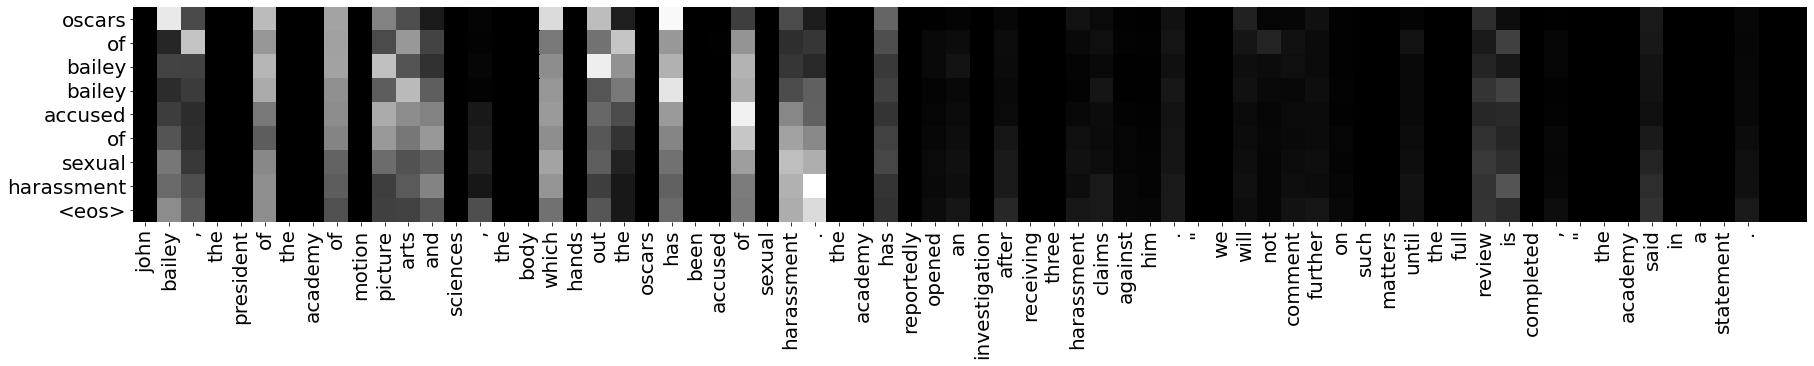

In [ ]:
#testing
example_idx = 60

bold_start, bold_end = "\033[1m", "\033[0;0m"
text = vars(test_data.examples[example_idx])['text']
headline = vars(test_data.examples[example_idx])['headline']

print(f'{bold_start}Text{bold_end} = {" ".join(word for word in text)}\n')
print(f'{bold_start}Headline{bold_end} = {" ".join(word for word in headline)}\n')

prediction, attention = predict(text, ARTICLE, SUMMARY, model, device)

print(f'{bold_start}Predicted Headline{bold_end} = {" ".join(word for word in prediction)}')
print("\n\t\t\t\t\t\t\tAttention Plot")
plot_attention(text, prediction, attention)

Text = us president donald trump has accused " fake media " and " dishonest people " of not reporting his criticism of hatred and white supremacy in response to the virginia violence which killed one woman . addressing a rally in the us city of phoenix , he further accused the media of " not liking the us " and providing a platform to hate groups .

Headline = ' fake media ' did not report my criticism of hatred : trump

Predicted Headline = fake fake fake media not not criticism of hatred : trump <eos>

							Attention Plot


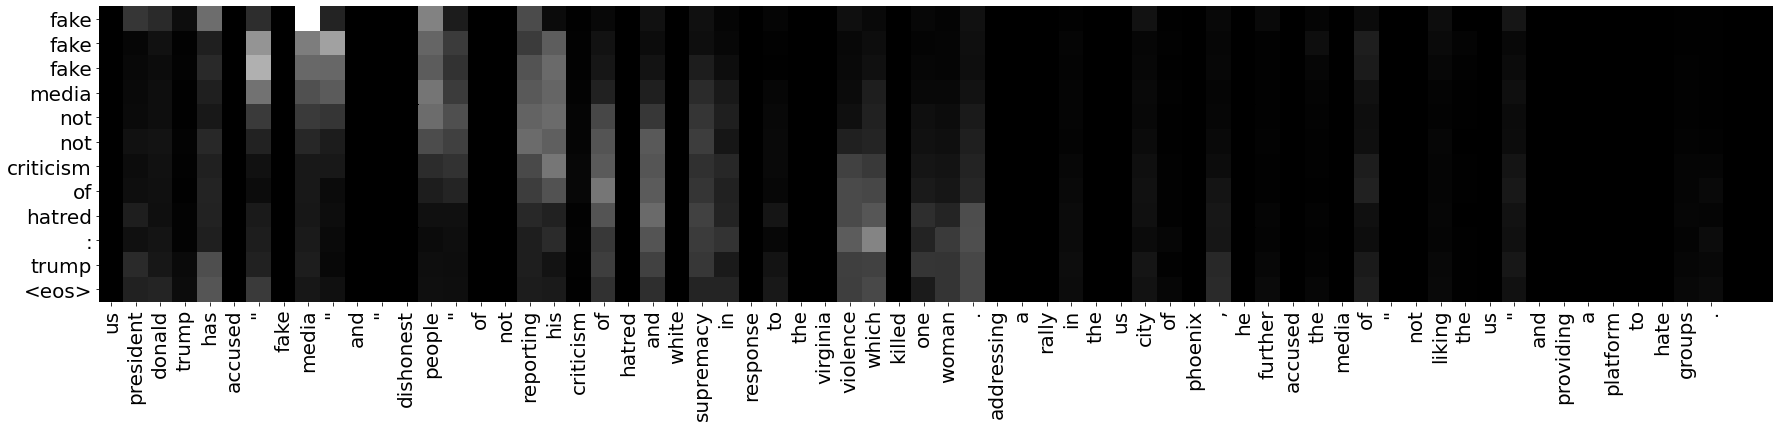

In [ ]:
example_idx = 1

bold_start, bold_end = "\033[1m", "\033[0;0m"
text = vars(test_data.examples[example_idx])['text']
headline = vars(test_data.examples[example_idx])['headline']

print(f'{bold_start}Text{bold_end} = {" ".join(word for word in text)}\n')
print(f'{bold_start}Headline{bold_end} = {" ".join(word for word in headline)}\n')

prediction, attention = predict(text, ARTICLE, SUMMARY, model, device)

print(f'{bold_start}Predicted Headline{bold_end} = {" ".join(word for word in prediction)}')
print("\n\t\t\t\t\t\t\tAttention Plot")
plot_attention(text, prediction, attention)